In [4]:
import torch
import triton
import triton.language as tl
from triton.runtime import driver

In [5]:
DEVICE = torch.device('cuda:0')
properties = driver.active.utils.get_device_properties(DEVICE.index)
print(f"{properties=}")
NUM_SM = properties["multiprocessor_count"]
NUM_REGS = properties["max_num_regs"]
SIZE_SMEM = properties["max_shared_mem"]
WARP_SIZE = properties["warpSize"]
target = triton.runtime.driver.active.get_current_target()
kernels = {}

properties={'max_shared_mem': 101376, 'max_num_regs': 65536, 'multiprocessor_count': 64, 'warpSize': 32, 'sm_clock_rate': 1695000, 'mem_clock_rate': 8001000, 'mem_bus_width': 384}


In [30]:
@triton.jit
def matmul_kernel(A: torch.Tensor, 
                  B: torch.Tensor, 
                  C: torch.Tensor, 
                  M: int, K: int, N: int, BLOCK_SIZE: tl.constexpr):
    
    row = tl.program_id(0)
    col = tl.program_id(1)
    
    offsets_m = row * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    offsets_n = col * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    
    accumulator = tl.zeros((BLOCK_SIZE, BLOCK_SIZE), dtype=tl.float32)

    for k in range(0, K, BLOCK_SIZE):
        offsets_k = k + tl.arange(0, BLOCK_SIZE)
        A_ptr = A + offsets_m[:, None] * K + offsets_k[None, :]
        B_ptr = B + offsets_k[:, None] * N + offsets_n[None, :]
        
        mask_A = (offsets_m[:, None] < M) & (offsets_k[None, :] < K)
        mask_B = (offsets_k[:, None] < K) & (offsets_n[None, :] < N)
        a = tl.load(A_ptr, mask=mask_A, other=0.0) # B, k
        b = tl.load(B_ptr, mask=mask_B, other=0.0) # k, B
        accumulator += tl.dot(a, b) # B, B
    
    C_ptr = C + offsets_m[:, None] * N + offsets_n[None, :]
    mask_C = (offsets_m[:, None] < M) & (offsets_n[None, :] < N)
    tl.store(C_ptr, accumulator, mask=mask_C)
    

In [31]:
def matmul(a: torch.Tensor, b:torch.Tensor) -> torch.Tensor:
    
    assert a.shape[-1] == b.shape[-2], f"a's rows should match b's cols, got: {a.shape=} and {b.shape=}"
    M, K = a.shape # Shape: M, K
    _, N = b.shape
    c = torch.zeros((M, N), dtype=a.dtype, device=a.device)
    # The block size of each loop iteration is the smallest power of two greater than the number of columns in `x`
    BLOCK_SIZE = 64 #triton.next_power_of_2(n_cols)
    grid= ((M + BLOCK_SIZE - 1) // BLOCK_SIZE, (N + BLOCK_SIZE - 1) // BLOCK_SIZE)
    matmul_kernel[grid](a, b, c, M, K, N, BLOCK_SIZE=BLOCK_SIZE)
    return c

In [32]:
torch.manual_seed(0)
a = torch.randn((512, 512), device=DEVICE, dtype=torch.float32)
b = torch.randn((512, 512), device=DEVICE, dtype=torch.float32)
triton_output = matmul(a, b)
torch_output = torch.matmul(a, b)
if torch.allclose(triton_output, torch_output, atol=0.125, rtol=0):
    print("✅ Triton and Torch match")
else:
    print("❌ Triton and Torch differ")

✅ Triton and Torch match


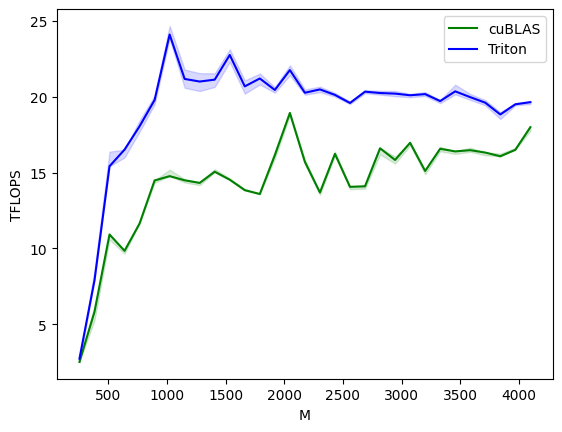

matmul-performance-fp32:
         M       N       K     cuBLAS     Triton
0    256.0   256.0   256.0   2.520615   2.730667
1    384.0   384.0   384.0   5.820632   7.899428
2    512.0   512.0   512.0  10.922666  15.420235
3    640.0   640.0   640.0   9.846154  16.516129
4    768.0   768.0   768.0  11.641264  18.055837
5    896.0   896.0   896.0  14.483794  19.787718
6   1024.0  1024.0  1024.0  14.768676  24.105195
7   1152.0  1152.0  1152.0  14.495068  21.177192
8   1280.0  1280.0  1280.0  14.321679  21.005128
9   1408.0  1408.0  1408.0  15.060155  21.130916
10  1536.0  1536.0  1536.0  14.533651  22.758482
11  1664.0  1664.0  1664.0  13.844480  20.687154
12  1792.0  1792.0  1792.0  13.590597  21.206460
13  1920.0  1920.0  1920.0  16.149533  20.449703
14  2048.0  2048.0  2048.0  18.935910  21.760332
15  2176.0  2176.0  2176.0  15.709327  20.265507
16  2304.0  2304.0  2304.0  13.689325  20.487025
17  2432.0  2432.0  2432.0  16.239574  20.124974
18  2560.0  2560.0  2560.0  14.063519  19.59

In [38]:
configs = []
ref_lib = "cuBLAS"
configs.append(
    triton.testing.Benchmark(
        x_names=["M", "N", "K"],  # Argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 33)],  # Different possible values for `x_name`
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        # Don't compare to cublas for fp8 cases as torch.matmul doesn't support fp8 at the moment.
        line_vals=[ref_lib.lower(), "triton"] , # Label name for the lines
        line_names=[ref_lib, "Triton"],  # Line styles
        styles=[("green", "-"), ("blue", "-")],
        ylabel="TFLOPS",  # Label name for the y-axis
        plot_name="matmul-performance-" +
        ("fp32"),  # Name for the plot, used also as a file name for saving the plot.
         args={},
    ))


@triton.testing.perf_report(configs)
def benchmark(M, N, K, provider):
    a = torch.randn((M, K), device=DEVICE, dtype=torch.float32)
    b = torch.randn((K, N), device=DEVICE, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == ref_lib.lower():
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(a, b), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul(a, b), quantiles=quantiles)
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


print(benchmark.run(show_plots=True, print_data=True))